# Desafio Cientista de Dados 2025 - Indicium

**Autor:** Matheus Augusto Fabri

Este notebook contém a análise desenvolvida para o Desafio Cientista de Dados 2025 da Indicium. O desafio consiste em realizar uma análise exploratória de dados em uma tabela de filmes retirados do IMDB (Internet Movie Database) e criar então um modelo de aprendizado de máquina que infereriria um dos componentes desta tabela, no caso a nota do IMDB, dadas as informações do filme em questão. O conjunto de dados consiste em um arquivo `csv` (em anexo com este notebook) contendo 999 filmes e 15 colunas com as seguintes informações:

- Series_Title – Nome do filme
- Released_Year - Ano de lançamento
- Certificate - Classificação etária
- Runtime – Tempo de duração
- Genre - Gênero
- IMDB_Rating - Nota do IMDB
- Overview - Overview do filme
- Meta_score - Média ponderada de todas as críticas 
- Director – Diretor
- Star1 - Ator/atriz #1
- Star2 - Ator/atriz #2
- Star3 - Ator/atriz #3
- Star4 - Ator/atriz #4
- No_of_Votes - Número de votos
- Gross - Faturamento

Logo este projeto consiste em analisar este conjunto conjunto de dados e criar um modelo para inferir o IMDB_Rating dadas as demais 14 informações. A seguir temos as bibliotecas utilizadas neste projeto e também as suas versões:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print('Versão pandas:', pd.__version__)
print('Versão numpy:', np.__version__)
print('Versão matplotlib:', matplotlib.__version__)
print('Versão seaborn:', sns.__version__)
print('Versão sklearn:', sklearn.__version__)
print('Versão pickle:', pickle.format_version)
print('Versão python:')
!python --version

Versão pandas: 2.2.2
Versão numpy: 1.26.4
Versão matplotlib: 3.9.2
Versão seaborn: 0.13.2
Versão sklearn: 1.5.1
Versão pickle: 4.0
Versão python:
Python 3.12.7


Para melhor conveniência, ao longo do projeto vamos também importar para o namespace local alguns módulos específicos destas bibliotecas. Este notebook é estruturado da seguinte maneira:

<!-- 1. **Pré-processamento dos dados:** Aqui carregamos o conjunto de dados, entendemos a sua estruturação, checamos a presença de valores nulos e criamos um DataFrame pronto para a análise exploratória. -->
1. **Análise exploratória dos dados (EDA):** Aqui carregamos o conjunto de dados, entendemos a sua estruturação, checamos a presença de valores nulos e criamos um DataFrame pronto para a análise exploratória. Dado isso, realizamos então uma análise estatística dos dados e buscamos entender que variáveis poderiam influenciar na predição do nosso alvo que seria a nota IMDB.
2. **Modelos para predição da nota IMDB:** Com os passos anteriores feitos criamos e treinamos modelos para prever a nota IMDB de um dado filme. Os modelos que consideraremos aqui são regressão linear, regressão linear com features polinomiais (introduzindo assim não linearidade), support vector machine para regressão com kernels linear e não lineares e decision trees de regressão.
3. **Resultados e conclusão:** Encerramos então com ponderações sobre os modelos utilizados, a eficácia e limite de cada um deles e como melhorar a análise dada aqui.

Este notebook contém também um arquivo auxiliar `functions.py` que usaremos para guardar algumas funções criadas para a análise. Este será carregado como:

In [2]:
import functions as ft

Dado isso comecemos então o projeto.

# Análise Exploratória dos dados (EDA):

## Carregamento dos dados:

Comecemos então carregando os dados, estes estão no arquivo `desafio_indicium_imdb.csv`. Logo:

In [3]:
data_imdb = pd.read_csv('desafio_indicium_imdb.csv', index_col=0, header=0)
data_imdb.shape

(999, 15)

Vemos então que temos 999 filmes com 15 colunas. Uma amostra é dada por:

In [4]:
data_imdb.head(2)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


Comecemos com uma descrição mais detalhada do DataFrame:

In [5]:
data_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


Vemos então as 15 colunas, notemos alguns ponts já de antemão:

- Somente as colunas Certificate, Meta_score e Gross possuem entradas nulas;
- Os campos Released_Year, Runtime e Gross deveriam ser numéricas mas são do tipo `object`. Mais precisamente Released_Year é categórico, todavia para os nossos propósitos podemos considerar estes como númericos e discutiremos a categorização posteriormente.

Vejamos primeiramente o número de entradas nulas:

In [6]:
data_imdb.isnull().sum()[data_imdb.isnull().sum() != 0]

Certificate    101
Meta_score     157
Gross          169
dtype: int64

Aonde com este query selecionamos somente as colunas com dados nulos. Vemos um número significativo de entradas nulas nestas colunas (acima de 10%). Vejamos também se há duplicatas nos dados, para isso usamos:

In [7]:
data_imdb.nunique()

Series_Title     998
Released_Year    100
Certificate       16
Runtime          140
Genre            202
IMDB_Rating       16
Overview         999
Meta_score        63
Director         548
Star1            659
Star2            840
Star3            890
Star4            938
No_of_Votes      998
Gross            822
dtype: int64

A maioria das colunas possuem repetições, o que é totalmente válido dado que existem múltiplos filmes que compartilham ano de lançamento, tempo de duração, diretor, gênero, atores e outros. No entanto é curioso que temos 2 filmes com o mesmo título. De fato temos:

In [8]:
data_imdb[data_imdb.duplicated(subset='Series_Title', keep=False)]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
87,Drishyam,2013,U,160 min,"Crime, Drama, Thriller",8.3,A man goes to extreme lengths to save his fami...,NaN,Jeethu Joseph,Mohanlal,Meena,Asha Sharath,Ansiba,30722,NaN
136,Drishyam,2015,UA,163 min,"Crime, Drama, Mystery",8.2,Desperate measures are taken by a man who trie...,NaN,Nishikant Kamat,Ajay Devgn,Shriya Saran,Tabu,Rajat Kapoor,70367,"739,478"


Porém notamos que apesar do título ser o mesmo estes possuem diferentes características e portanto são filmes distintos. Discutiremos agora o processamento das colunas e entradas nulas.

## Processamento de colunas:

Antes de lidar com as entradas nulas comecemos convertendo as colunas Released_Year, Runtime e Gross para o tipo númerico. Comecemos com Released_Year, para isso basta usar o módulo `to_numeric` do pandas:

In [9]:
data_imdb['Released_Year'] = pd.to_numeric(data_imdb['Released_Year'], errors='coerce')
print('Tipo da coluna Released_Year:', data_imdb['Released_Year'].dtype)

Tipo da coluna Released_Year: float64


Note o uso de `errors='coerce'` é necessário dado que existem entradas não númericas e para estas a função em questão converte para `NaN`. Vemos então que a conversão foi bem sucedida. Vejamos agora a coluna Runtime, esta possui o padrão 'XXX min':

In [10]:
data_imdb['Runtime'].head()

1    175 min
2    152 min
3    202 min
4     96 min
5    201 min
Name: Runtime, dtype: object

Logo usamos a função `process_runtime` do nosso módulo para processar esta coluna:

In [11]:
data_imdb['Runtime'] = data_imdb['Runtime'].apply(ft.process_runtime)
print('Tipo da coluna Runtime:', data_imdb['Runtime'].dtype)

Tipo da coluna Runtime: int64


Logo a coluna Runtime agora nos dá o tempo de duração do filme em minutos. Por fim convertemos a coluna Gross em númerica e para isso usamos a função `gross_converter` do nosso módulo:

In [12]:
data_imdb['Gross'] = data_imdb['Gross'].apply(ft.gross_converter)/1e6
print('Tipo da coluna Gross:', data_imdb['Gross'].dtype)

Tipo da coluna Gross: float64


Note que dividimos o faturamento do filme por 1 milhão e então agora este é dado em unidades de milhões de USD. Com as colunas numéricas processadas podemos agora lidar com a coluna Genre. Peguemos 10 filmes e seus gêneros:

In [13]:
data_imdb[['Series_Title', 'Genre']].head(5)

,Series_Title,Genre
1,The Godfather,"Crime, Drama"
2,The Dark Knight,"Action, Crime, Drama"
3,The Godfather: Part II,"Crime, Drama"
4,12 Angry Men,"Crime, Drama"
5,The Lord of the Rings: The Return of the King,"Action, Adventure, Drama"


Vemos que um dado filme possui múltiplos gêneros, contudo o primeiro gênero da lista parece ser o gênero principal do filme. Logo para facilitar a nossa análise vamos assumir isto e então considerar somente o gênero principal. Para isso usemos a função `genre_preprocess` do nosso módulo:

In [14]:
data_imdb['Genre'] = data_imdb['Genre'].apply(ft.genre_preprocess)
data_imdb[['Series_Title', 'Genre']].head(5)

,Series_Title,Genre
1,The Godfather,Crime
2,The Dark Knight,Action
3,The Godfather: Part II,Crime
4,12 Angry Men,Crime
5,The Lord of the Rings: The Return of the King,Action


Isso reduzirá significativamente o número de variáveis em nosso encoder na nossa modelagem a seguir. Por conveniência agregamos todas estas transformações na função `get_data` do nosso módulo:

In [15]:
data_imdb = ft.get_data()
data_imdb.head(3)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972.0,A,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134.966411
2,The Dark Knight,2008.0,UA,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534.858444
3,The Godfather: Part II,1974.0,A,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57.300000


## Processamento de entradas NaN:

Agora podemos processar as entradas nulas em nossos dados:

In [16]:
data_imdb.isnull().sum()[data_imdb.isnull().sum() != 0]

Released_Year      1
Certificate      101
Meta_score       157
Gross            169
dtype: int64

Note agora que uma entrada nula em Released_Year em relação a antes pois estamos usando o conjunto de dados com as colunas processadas usando `get_data` do nosso módulo. A maneira mais simples de se lidar com este problema é descartar todos os filmes com campos nulos. Isto é feito como:

In [17]:
data_imdb.dropna(axis='rows').shape

(712, 15)

Vemos então uma redução significativa dos dados pasa somente 712 entradas. Dado que nossos dados já são escassos poderíamos pensar em desconsiderar somente as colunas que entradas nulas aparecem e não os filmes em si:

In [18]:
data_imdb.dropna(axis='columns').shape

(999, 11)

Temos então todos os filmes, no entanto as colunas Released_Year, Certificate, Meta_score e Gross foram descartadas. Aqui assumiremos que estas possuem uma influência na nota IMDB de um filme e portanto são relevantes para a nossa análise pois desejamos manter o maior número possível de variáveis. Dado isto manteremos estas colunas e usaremos métos um pouco mais refinados para lidar com valores nulos. No caso das colunas Released_Year e Certificate não há muito o que fazer pois é díficil inferir o ano de lançamento e a classificação indicativa de um filme somente dos dados deste, logo vamos simplesmente descartar estas entradas:

In [19]:
data_imdb = data_imdb.dropna(subset=['Certificate', 'Released_Year'])
data_imdb.shape

(897, 15)

O que não reduziu tanto os nossos dados. Agora para a coluna Gross nós iremos substituir os valores nulos por médias. Contudo não simplesmente uma média geral mas uma média por gênero e por ano, isto é, se um filme de ação em 1967 possui faturamento nulo consideraremos o faturamento médio de todos os filmes de ação de 1967 como o faturamento deste filme. Fizemos isto o faturamento varia significativamente por gênero e por ano:

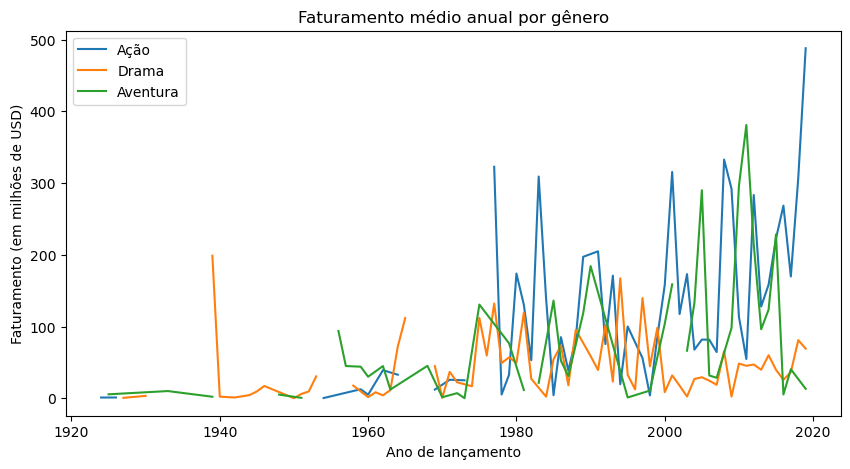

In [20]:
ax = data_imdb.groupby(by=['Genre', 'Released_Year'])['Gross'].mean()['Action'].plot(label='Ação', figsize=(10,5))
data_imdb.groupby(by=['Genre', 'Released_Year'])['Gross'].mean()['Drama'].plot(ax=ax, label='Drama')
data_imdb.groupby(by=['Genre', 'Released_Year'])['Gross'].mean()['Adventure'].plot(ax=ax, label='Aventura')
plt.title('Faturamento médio anual por gênero')
plt.xlabel('Ano de lançamento')
plt.ylabel('Faturamento (em milhões de USD)')
plt.legend()
plt.show()

Já para o Meta_score assumiremos que este independe do ano de lançamento e somente do gênero dado que é um conjunto de notas agregadas da crítica. Com isso as vamos substituir os `NaN` da coluna Meta_score com a médio por genero de filme. As funções que realizam estas operações são dadas por `replace_metascore_nan` e `replace_gross_nan` em nosso módulo. Por exemplo para o metascore:

In [21]:
data_imdb_clean = ft.replace_metascore_nan(data_imdb)

Peguemos cinco exemplos sem Meta_score no dataset original:

In [22]:
data_imdb[data_imdb['Meta_score'].isna()][['Series_Title', 'Meta_score', 'Genre']].head(5)

,Series_Title,Meta_score,Genre
20,Soorarai Pottru,NaN,Drama
55,Vikram Vedha,NaN,Action
57,Dangal,NaN,Action
65,Taare Zameen Par,NaN,Drama
71,Once Upon a Time in America,NaN,Crime


Agora estes mesmo cinco exemplos seriam:

In [23]:
data_imdb_clean[data_imdb['Meta_score'].isna()][['Series_Title', 'Meta_score', 'Genre']].head(5)

,Series_Title,Meta_score,Genre
20,Soorarai Pottru,79.156682,Drama
55,Vikram Vedha,73.529412,Action
57,Dangal,73.529412,Action
65,Taare Zameen Par,79.156682,Drama
71,Once Upon a Time in America,75.987179,Crime


Façamos o mesmo com a coluna Gross:

In [24]:
data_imdb_clean = ft.replace_gross_nan(data_imdb_clean)

Peguemos então cinco exemplos com faturamento nulo:

In [25]:
data_imdb[data_imdb['Gross'].isna()][['Series_Title', 'Gross', 'Genre', 'Released_Year']].head(5)

,Series_Title,Gross,Genre,Released_Year
18,Hamilton,NaN,Biography,2020.0
20,Soorarai Pottru,NaN,Drama,2020.0
32,It's a Wonderful Life,NaN,Drama,1946.0
46,Hotaru no haka,NaN,Animation,1988.0
55,Vikram Vedha,NaN,Action,2017.0


E comparemos com o DataFrame com NaN de Gross substituídos:

In [26]:
data_imdb_clean[data_imdb['Gross'].isna()][['Series_Title', 'Gross', 'Genre', 'Released_Year']].head(5)

,Series_Title,Gross,Genre,Released_Year
18,Hamilton,NaN,Biography,2020.0
20,Soorarai Pottru,NaN,Drama,2020.0
32,It's a Wonderful Life,17.057000,Drama,1946.0
46,Hotaru no haka,52.703702,Animation,1988.0
55,Vikram Vedha,169.741044,Action,2017.0


Vemos que nem todos os valores foram substituídos pois ainda existem alguns valores não nulos. Isto ocorre pois em determinados anos há somente um filme daquele gênero e este tem faturamento nulo e portanto não é possível calcular a média. De fato temos que em 2020 só houve um filme biográfico lançado e este é de fato Hamilton:

In [27]:
data_imdb[(data_imdb['Released_Year']==2020) & (data_imdb['Genre']=='Biography')]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
18,Hamilton,2020.0,PG-13,160,Biography,8.6,The real life of one of America's foremost fou...,90.0,Thomas Kail,Lin-Manuel Miranda,Phillipa Soo,Leslie Odom Jr.,Renée Elise Goldsberry,55291,NaN


Com essas limpeza nos valores nulos feitos vemos então que ainda há alguns valores nulos:

In [28]:
data_imdb_clean.isnull().sum()[data_imdb_clean.isnull().sum()!= 0]

Gross    48
dtype: int64

Para esses nós somente os desconsideramos e então obtemos:

In [29]:
data_imdb_clean = data_imdb_clean.dropna(axis='rows')
data_imdb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 849 entries, 1 to 997
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   849 non-null    object 
 1   Released_Year  849 non-null    float64
 2   Certificate    849 non-null    object 
 3   Runtime        849 non-null    int64  
 4   Genre          849 non-null    object 
 5   IMDB_Rating    849 non-null    float64
 6   Overview       849 non-null    object 
 7   Meta_score     849 non-null    float64
 8   Director       849 non-null    object 
 9   Star1          849 non-null    object 
 10  Star2          849 non-null    object 
 11  Star3          849 non-null    object 
 12  Star4          849 non-null    object 
 13  No_of_Votes    849 non-null    int64  
 14  Gross          849 non-null    float64
dtypes: float64(4), int64(2), object(9)
memory usage: 106.1+ KB


Temos então 15 colunas com 849 entradas não nulas e com as colunas devidamente processadas. Com todas estas alterações realizadas salvemos então este DataFrame:

In [30]:
data_imdb_clean.to_csv('data_imdb_cleaned.csv', index=False)
data_imdb_clean = pd.read_csv('data_imdb_cleaned.csv')

## Insights acerca dos dados:

Com o o dataset já limpo e devidamente organizado podemos então realizar algumas análises. Por exemplo podemos buscar quais os os 10 filmes com maior faturamento:

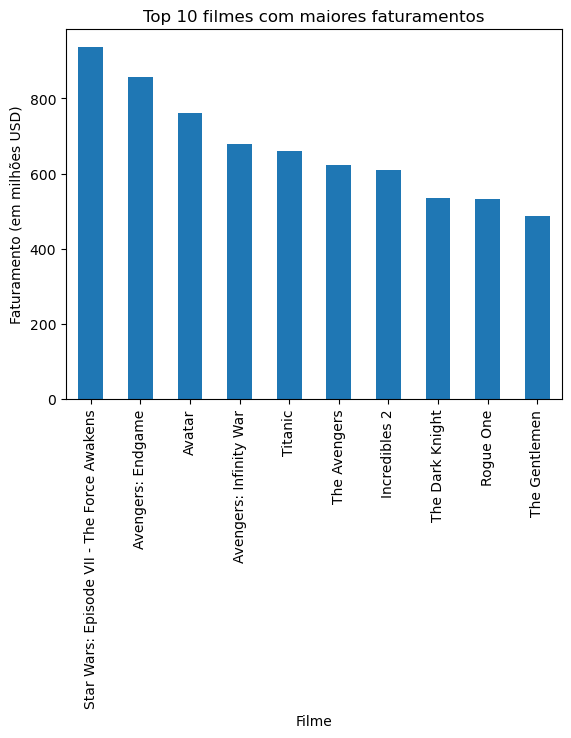

In [31]:
data_imdb_clean[['Series_Title', 'Gross']].sort_values(by='Gross', ascending=False).head(10).plot.bar(x='Series_Title', y='Gross', legend=False)
plt.xlabel('Filme')
plt.ylabel('Faturamento (em milhões USD)')
plt.title('Top 10 filmes com maiores faturamentos')
plt.show()

O que de fato parece fazer sentido, dado que estes filmes em geral são de franquias bem estabelecidas e com altos faturamentos como filmes da Marvel ou Star Wars. Podemos também verificar os maiores diretores em relação ao faturamento médio por filme:

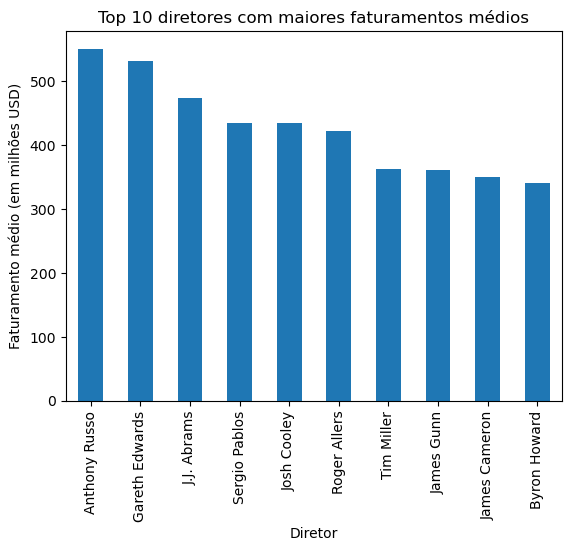

In [32]:
data_imdb_clean.groupby(by='Director')['Gross'].mean().sort_values(ascending=False).head(10).plot.bar()
plt.xlabel('Diretor')
plt.ylabel('Faturamento médio (em milhões USD)')
plt.title('Top 10 diretores com maiores faturamentos médios')
plt.show()

O que difere significativamente de uma classificação em relação ao faturamento total de cada diretor:

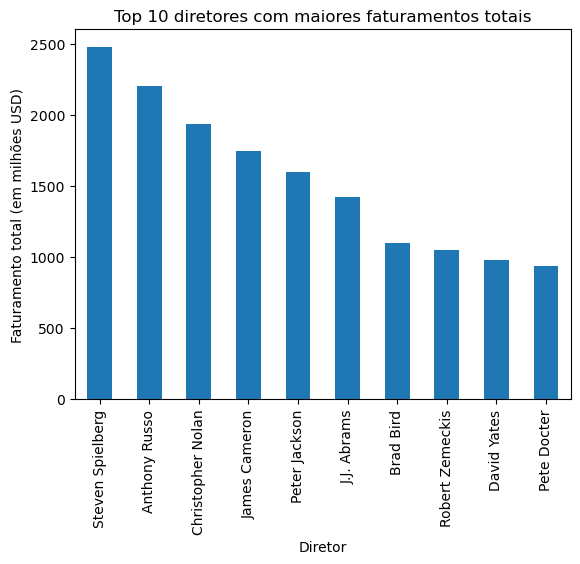

In [33]:
data_imdb_clean.groupby(by='Director')['Gross'].sum().sort_values(ascending=False).head(10).plot.bar()
plt.xlabel('Diretor')
plt.ylabel('Faturamento total (em milhões USD)')
plt.title('Top 10 diretores com maiores faturamentos totais')
plt.show()

Uma razão para isso é que há diretores como Peter Jackson ou Christopher Nolan que possuem muitos filmes com um faturamento menor que puxam a média para baixo. Por exemplo, Peter Jackson e Christopher Nolan tem faturamentos médios de aproximadamente 248 e 319 milhões de dólares, respectivamente, apesar de terem faturamentos superiores a 1 bilhão de dólares. 

A nossa variável alvo para prevermos é a nota IMDB, analisemos então o comportamento desta. Uma primeira pergunta seria: qual é a relação entre a nota IMDB e a nota agregada da crítica (Meta_score)? O quão distintas ou similares estas são?

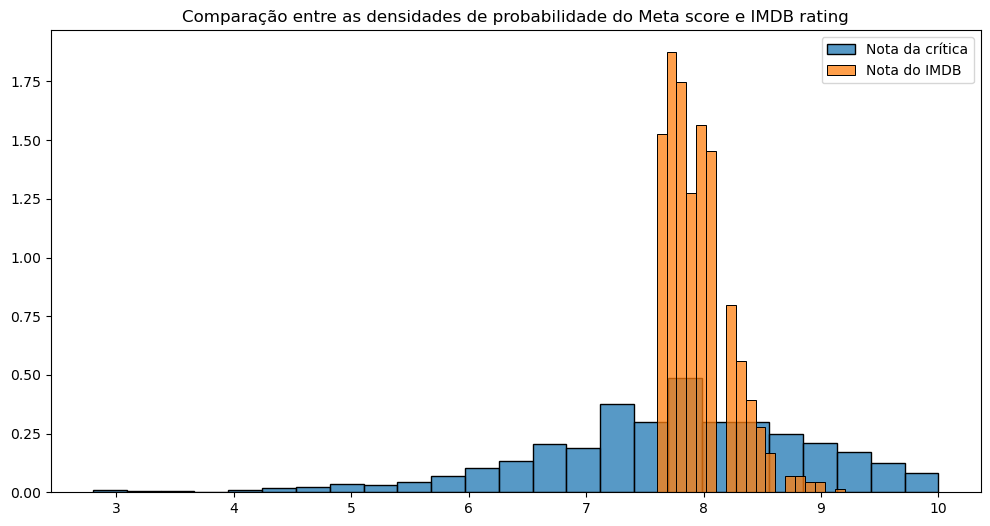

In [34]:
plt.figure(figsize=(12,6))
ax = sns.histplot(data_imdb_clean[['Meta_score']]/10, x='Meta_score', stat='density', label='Nota da crítica')
sns.histplot(data=data_imdb_clean, x='IMDB_Rating', stat='density', ax=ax, label='Nota do IMDB')
plt.xlabel('')
plt.ylabel('')
plt.title('Comparação entre as densidades de probabilidade do Meta score e IMDB rating')
plt.legend()
plt.show()

Note que aqui dividimos a nota da crítica por 10 para colocá-la na mesma escala da nota do IMDB. Uma primeira coisa que podemos ver é que as avaliações do IMDB são estritamente positivas, isto é, maiores que sete. Isto nos leva a crer que este dataset é formado somente pelos primeiros 999 filmes mais bem avaliados pelos usuários. Podemos ver também que a nota da crítica possui uma amplitude bem maior que a nota do IMBD, de fato o público do IMDB parece ser bem mais leniente com os filmes que a crítica. Isto é possível de ser visto nas estatísticas descritivas dadas abaixo:

In [35]:
data_imdb_clean[['Meta_score', 'IMDB_Rating']].describe()

,Meta_score,IMDB_Rating
count,849.000000,849.000000
mean,77.317591,7.951355
std,11.650678,0.280332
min,28.000000,7.600000
25%,71.000000,7.700000
50%,78.088496,7.900000
75%,85.000000,8.100000
max,100.000000,9.200000


Vemos que o desvio padrão das notas da crítica chegam a ser ~15% da média enquanto no caso da nota do IMDB ficam em volta de ~3.6% o que explica o fato da distribuição da nota da crítica ser mais espalhada. Essa divisão crítica/público pode ser vista com mais detalhes notando que o IMDB_Rating nunca fica abaixo de 7.6 enquanto o Meta_score pode chegar a valores baixissímos como 28. De fato podemos facilmente extrair todos os filmes com Meta_score abaixo de 45 e vemos a disparidade em relação a nota de público:

In [36]:
data_imdb_clean[data_imdb_clean['Meta_score']<45][['Series_Title', 'Meta_score', 'IMDB_Rating']].sort_values(by='Meta_score')

,Series_Title,Meta_score,IMDB_Rating
668,I Am Sam,28.0,7.7
799,The Butterfly Effect,30.0,7.6
309,Tropa de Elite,33.0,8.0
776,Seven Pounds,36.0,7.6
620,Kai po che!,40.0,7.7
813,Fear and Loathing in Las Vegas,41.0,7.6
550,The Boondock Saints,44.0,7.8


Vemos que a crítica especializada não gostou de Tropa de Elite! Esta separação entre crítica/público ocorre não somente para filmes com Meta_score baixo mas também para filmes com Meta_score alto:

In [37]:
data_imdb_clean[data_imdb_clean['Meta_score']==100][['Series_Title', 'Meta_score', 'IMDB_Rating']].sort_values(by='IMDB_Rating').head(5)

,Series_Title,Meta_score,IMDB_Rating
416,Boyhood,100.0,7.9
474,Notorious,100.0,7.9
370,Il conformista,100.0,8.0
234,Trois couleurs: Rouge,100.0,8.1
247,Fanny och Alexander,100.0,8.1


Vemos que filmes considerados pela crítica como perfeitos chegam a ter uma nota do público bem mais baixa como é o caso de Boyhood mostrado acima. Temos que de fato a correlação entre as notas da crítica e público não chega a ser alta:

In [38]:
data_imdb_clean[['Meta_score', 'IMDB_Rating']].corr()

,Meta_score,IMDB_Rating
Meta_score,1.000000,0.262659
IMDB_Rating,0.262659,1.000000


Para as colunas númericas podemos verificar a correlação entre elas, porém devemos antes extrair as variáveis numéricas:

In [39]:
num_cols = []
cat_cols = []
for col in data_imdb_clean.columns:
    col_types = data_imdb_clean.dtypes
    if col_types[col] != 'object':
        num_cols.append(col)
    else:
        cat_cols.append(col)
num_cols.remove('Released_Year')

Note que removemos ano de lançamento das variáveis numéricas dado que este é categórico e lidaremos com ela depois. Calculemos então a correlação entre as variáveis numéricas:

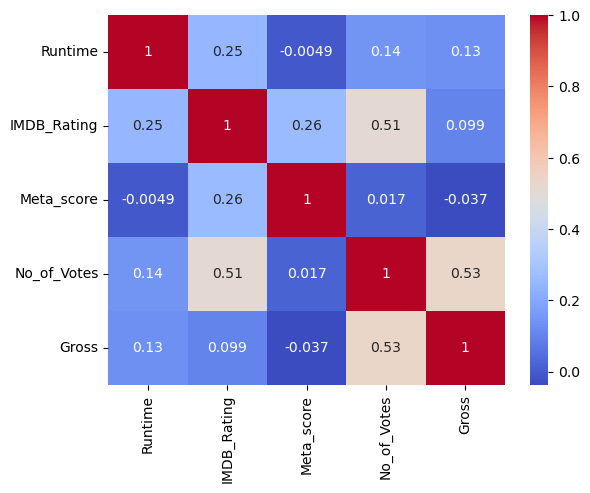

In [40]:
matrix_corr = data_imdb_clean[num_cols].corr()
sns.heatmap(data_imdb_clean[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

Como esperado, o número de votos é correlacionado positivamente com o faturamento e com a nota do IMDB dado que mais pessoas engajadas com um filme tendem a avaliá-lo e assisti-lo. Já a correlação entre as outras variáveis tende a ser baixa. Abaixo podemos ver a relação e histograma de todas as variáveis numéricas:

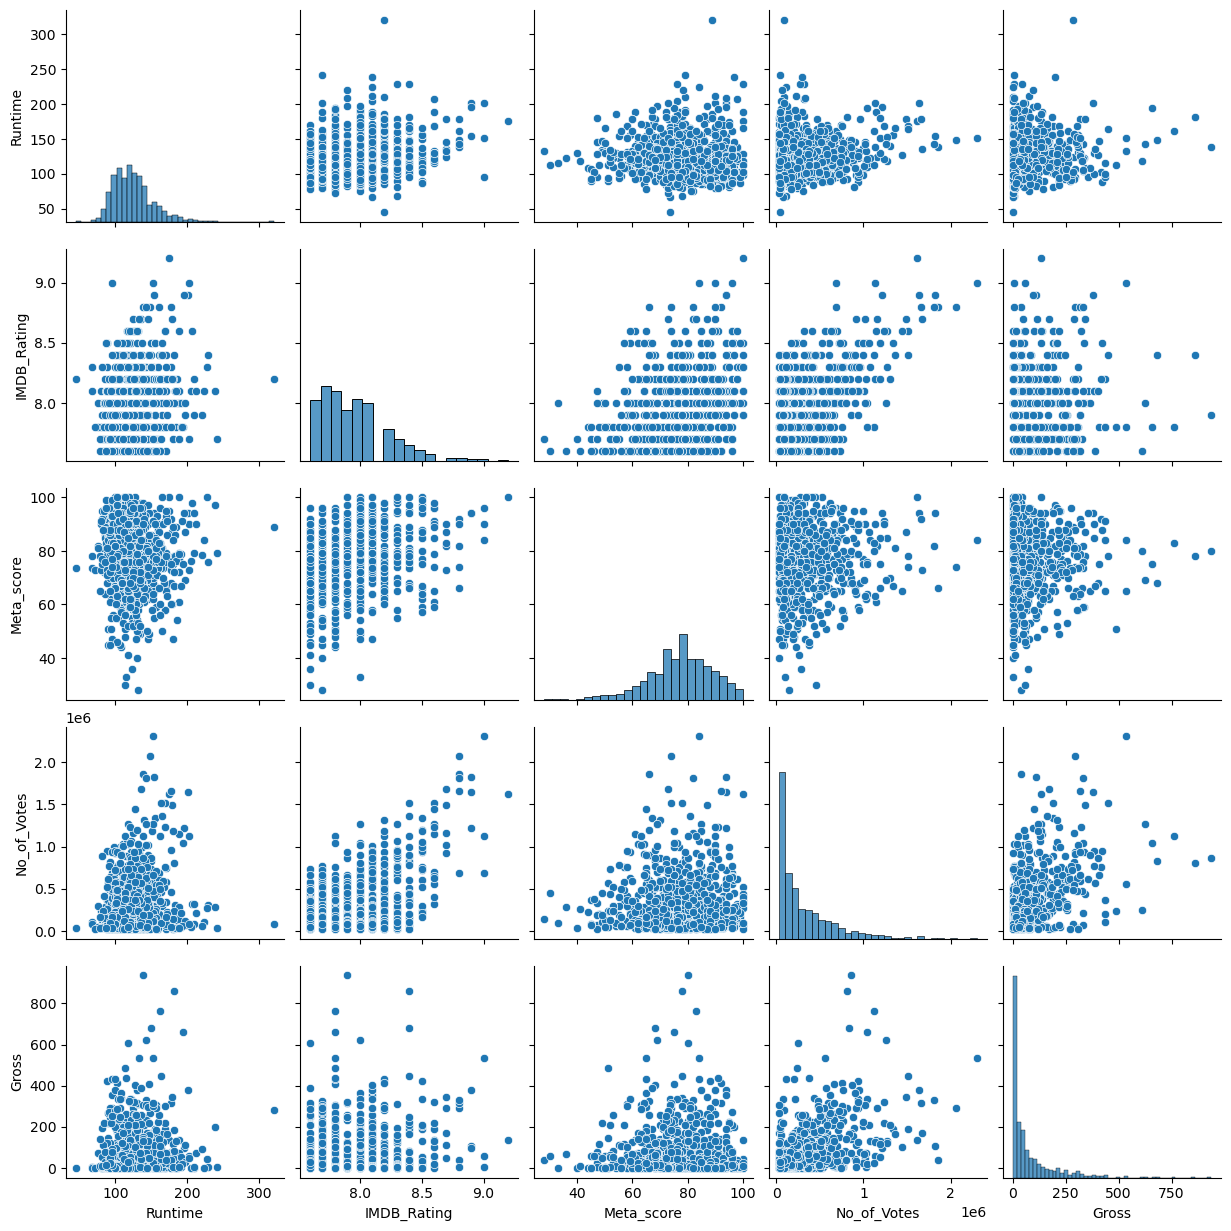

In [41]:
sns.pairplot(data_imdb_clean[num_cols])
plt.show()

Vemos que as relações entre as variáveis não chegam a ser aleatórias. De fato, precebe-se que conforme o número de votos aumenta o IMDB_Rating também aumenta oq eu explicaria a correlação positiva entre as variáveis. O mesmo ocorre com o IMDB_Rating e o Meta_score. Logo a relação entre as variáveis não é completamente aleatória, caso contrário teríamos uma correlação menor e pontos mais uniformemente espalhados nestes pairplots.

## Perguntas da Indicium:

Respondamos agora as perguntas dadas no desafio:

**a. Qual filme você recomendaria para uma pessoa que você não conhece?**

Caso a pessoa não de nenhuma informação de qual filme prefira penso que uma possibilidade seria indicar um dos 5 filmes mais bem avaliados pelo público, isto é, com IMBD_Rating mais alto. Estes seriam:

In [42]:
data_imdb_clean.sort_values(by='IMDB_Rating', ascending=False).head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972.0,A,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134.966411
2,The Godfather: Part II,1974.0,A,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57.300000
3,12 Angry Men,1957.0,U,96,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4.360000
1,The Dark Knight,2008.0,UA,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534.858444
4,The Lord of the Rings: The Return of the King,2003.0,U,201,Action,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377.845905


Dentre destes a pessoa poderia então ler a sinopse e ver qual filme seria mais do gosto dela. Outra opção seria coletar informações mais específicas acerca do gosto pessoal do alvo e então indicar os filmes com maior nota do público. Por exemplo, caso a pessoa goste de filmes de ação os filmes recomendados seriam:

In [43]:
data_imdb_clean[data_imdb_clean['Genre']=='Action'].sort_values(by='IMDB_Rating', ascending=False).head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Dark Knight,2008.0,UA,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534.858444
4,The Lord of the Rings: The Return of the King,2003.0,U,201,Action,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377.845905
7,Inception,2010.0,UA,148,Action,8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292.576195
9,The Lord of the Rings: The Fellowship of the Ring,2001.0,U,178,Action,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315.544750
12,The Lord of the Rings: The Two Towers,2002.0,UA,179,Action,8.7,While Frodo and Sam edge closer to Mordor with...,87.0,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,1485555,342.551365


Ou caso a pessoa goste de filmes do diretor Steven Spielberg os filmes recomendados seriam:

In [44]:
data_imdb_clean[data_imdb_clean['Director']=='Steven Spielberg'].sort_values(by='IMDB_Rating', ascending=False).head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
6,Schindler's List,1993.0,A,195,Biography,8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1213505,96.898818
21,Saving Private Ryan,1998.0,R,169,Drama,8.6,"Following the Normandy Landings, a group of U....",91.0,Steven Spielberg,Tom Hanks,Matt Damon,Tom Sizemore,Edward Burns,1235804,216.540909
67,Raiders of the Lost Ark,1981.0,A,115,Action,8.4,"In 1936, archaeologist and adventurer Indiana ...",85.0,Steven Spielberg,Harrison Ford,Karen Allen,Paul Freeman,John Rhys-Davies,884112,248.159971
155,Indiana Jones and the Last Crusade,1989.0,U,127,Action,8.2,"In 1938, after his father Professor Henry Jone...",65.0,Steven Spielberg,Harrison Ford,Sean Connery,Alison Doody,Denholm Elliott,692366,197.171806
218,Catch Me If You Can,2002.0,A,141,Biography,8.1,"Barely 21 yet, Frank is a skilled forger who h...",75.0,Steven Spielberg,Leonardo DiCaprio,Tom Hanks,Christopher Walken,Martin Sheen,832846,164.615351


Ou talvez a pessoa em questão seja fã de filmes que tenham o Tom Hanks, logo poderiamos selecionar todos os filmes que tenham o Tom Hanks e então classificá-los pela nota do IMDB. Assim os filmes seriam:

In [45]:
cond = (data_imdb_clean['Star1']=='Tom Hanks')|(data_imdb_clean['Star2']=='Tom Hanks')|(data_imdb_clean['Star3']=='Tom Hanks')|(data_imdb_clean['Star4']=='Tom Hanks')
data_imdb_clean[cond].sort_values(by='IMDB_Rating', ascending=False).head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
10,Forrest Gump,1994.0,UA,142,Drama,8.8,"The presidencies of Kennedy and Johnson, the e...",82.0,Robert Zemeckis,Tom Hanks,Robin Wright,Gary Sinise,Sally Field,1809221,330.252182
21,Saving Private Ryan,1998.0,R,169,Drama,8.6,"Following the Normandy Landings, a group of U....",91.0,Steven Spielberg,Tom Hanks,Matt Damon,Tom Sizemore,Edward Burns,1235804,216.540909
22,The Green Mile,1999.0,A,189,Crime,8.6,The lives of guards on Death Row are affected ...,61.0,Frank Darabont,Tom Hanks,Michael Clarke Duncan,David Morse,Bonnie Hunt,1147794,136.801374
93,Toy Story,1995.0,U,81,Animation,8.3,A cowboy doll is profoundly threatened and jea...,95.0,John Lasseter,Tom Hanks,Tim Allen,Don Rickles,Jim Varney,887429,191.796233
139,Toy Story 3,2010.0,U,103,Animation,8.2,The toys are mistakenly delivered to a day-car...,92.0,Lee Unkrich,Tom Hanks,Tim Allen,Joan Cusack,Ned Beatty,757032,415.004880


**b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?**

Para as variáveis numéricas podemos usar a matriz de correlação para testar a relação destas com o faturamento. Temos então que a correlação do faturamento com as variáveis numéricas é dado por:

In [46]:
matrix_corr.loc['Gross'].sort_values(ascending=False)

Gross          1.000000
No_of_Votes    0.534944
Runtime        0.132095
IMDB_Rating    0.098580
Meta_score    -0.036869
Name: Gross, dtype: float64

Neste caso vemos que o número de votos possui uma correlação positiva relativamente alta, pois como dissemos anteriormente filmes que tenham maior faturamento foram vistos por mais pessoas e portanto mais chances de serem avaliados. Um fator que pode influenciar fortemente no faturamento é o gênero do filme. De fato temos:

In [47]:
data_imdb_clean.groupby(by='Genre', observed=True)['Gross'].describe()[['count', 'mean', 'std']].sort_values(by='mean', ascending=False)

,count,mean,std
Genre,,,
Family,2.0,219.555277,304.841196
Action,152.0,152.612770,174.185350
Animation,76.0,129.972712,141.693240
Adventure,65.0,84.155143,99.112413
Horror,9.0,81.752078,76.805483
Biography,85.0,60.672335,57.858848
Drama,234.0,42.193373,69.121013
Crime,87.0,37.375970,52.107570
Comedy,125.0,33.440371,50.397970


Vemos que os maiores faturamentos médios são de filmes que possuem uma maior abrangência de público como por exemplo os gêneros Family, Action, Animation e Adventure. Isto é esperado dado que estes são filmes que atingem os chamados quatro quadrantes de telespectadores: crianças, adolescentes, adultos e idosos. Como discutido anteriormente, outro fator que parece ter grande influência também é o fato do filme pertencer ou não a uma franquia ou marca já estabelecida como por exemplo Star Wars, Disney ou filmes de heróis. Podemos ver isso abaixo:

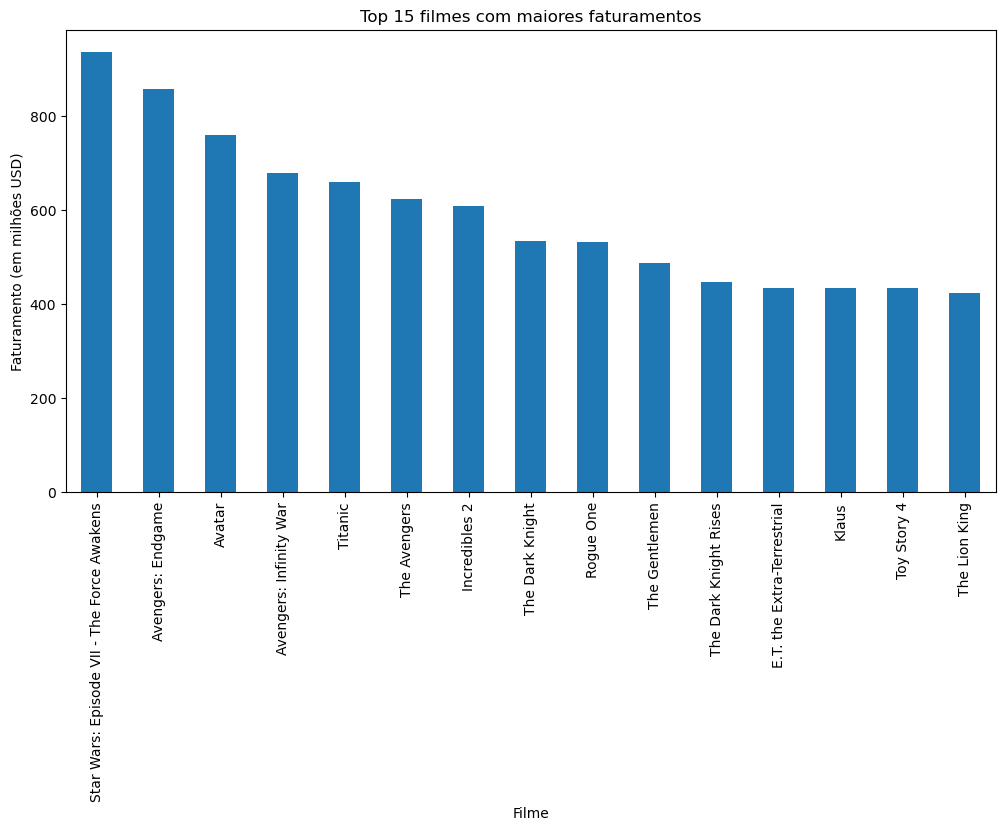

In [48]:
data_imdb_clean[['Series_Title', 'Gross']].sort_values(by='Gross', ascending=False).head(15).plot.bar(x='Series_Title', y='Gross', legend=False, figsize=(12,6))
plt.xlabel('Filme')
plt.ylabel('Faturamento (em milhões USD)')
plt.title('Top 15 filmes com maiores faturamentos')
plt.show()

Algumas anomalias com altas bilheterias porém de franquias não estabelecidas seriam os filmes do James Cameron ou Steven Spielberg, logo estes diretores também seriam indicativos de um alto faturamento.

**c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?**

Penso que seria possível extrair o gênero do filme da coluna Overview ou ainda tentar relacionar com outras variáveis como por exemplo a nota do IMDB. Penso que para isso seria necessário coletar um grande número de sinopses e usar um tokenizer para codificar a coluna Overview e então poderíamos criar uma modelo de aprendizado de máquina, digamos uma rede neural, para inferir variáveis como o IMDB_Rating dado o overview.

## Anos de Lançamentos e colunas categóricas:

Quando fizermos OneHotEncoding depois temos que cada entrada diferente em uma coluna categórica aumenta a dimensão do espaço de inputs. No nosso caso temos que usando OneHotEncoding para as colunas categóricas temos um espaço 5121-dimensional. De fato:

In [49]:
# a dimensão do espaço de inputs é o número de entradas únicas nas colunas categóricas mais o número de colunas numéricas menos o target que é IMDB_Rating
data_imdb_clean[cat_cols+['Released_Year']].nunique().sum() + len(num_cols) - 1

5121

Para facilitar a análise podemos reduzir o número de variáveis categóricas. Uma primeira mudança que podemos fazer é agrupar as colunas Released_Year por década. Isso reduz os inputs de Released_Year de um espaço 91-dimensional para um espaço 10-dimensional. O código abaixo usa o método `cut` de `pandas` para dividir Released_Year em 10 bins:

In [50]:
# labels das décadas para os bins
labels = [f'{x}s' for x in range(1920, 2010+1, 10)]
# cria um dataframe para agrupar por década
data_imdb_decade = data_imdb_clean.copy().drop(columns=['Released_Year'])
# uso de cut para o agrupamento de Released_Year
data_imdb_decade['Released_Decade']= pd.cut(data_imdb_clean['Released_Year'], bins=10, labels=labels)

Podemos ver o efeito desse agrupamento. Considere uma amostra do DataFrame original:

In [51]:
data_imdb_clean[['Series_Title', 'Released_Year']].head(3)

,Series_Title,Released_Year
0,The Godfather,1972.0
1,The Dark Knight,2008.0
2,The Godfather: Part II,1974.0


Agora para o DataFrame agrupado por década temos: 

In [52]:
data_imdb_decade[['Series_Title', 'Released_Decade']].head(3)

,Series_Title,Released_Decade
0,The Godfather,1970s
1,The Dark Knight,2000s
2,The Godfather: Part II,1970s


Logo o novo DataFrame seria:

In [53]:
data_imdb_decade.head(3)

,Series_Title,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Released_Decade
0,The Godfather,A,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134.966411,1970s
1,The Dark Knight,UA,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534.858444,2000s
2,The Godfather: Part II,A,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57.300000,1970s


Vemos abaixo que este agrupamento faz sentido pois a variação do IMDB_Rating dentro de cada década é baixa. De fato temos:

In [54]:
data_imdb_decade.groupby(by='Released_Decade', observed=True)['IMDB_Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
Released_Decade,,,,,,,,
1920s,7.0,8.142857,0.097590,8.0,8.100,8.10,8.200,8.3
1930s,17.0,8.070588,0.233893,7.7,7.900,8.00,8.100,8.5
1940s,15.0,8.133333,0.252605,7.7,7.950,8.10,8.300,8.6
1950s,34.0,8.082353,0.293847,7.6,7.900,8.05,8.275,9.0
1960s,42.0,7.966667,0.260081,7.6,7.800,7.95,8.100,8.8
1970s,66.0,7.992424,0.318801,7.6,7.800,8.00,8.100,9.2
1980s,86.0,7.954651,0.261515,7.6,7.725,7.90,8.100,8.7
1990s,142.0,7.957042,0.320106,7.6,7.700,7.90,8.100,8.9
2000s,215.0,7.906047,0.273111,7.6,7.700,7.80,8.100,9.0


Logo o maior desvio padrão do IMDB_Rating por década é no máximo aproximadamente 4% da média. No caso da classificação indicativa vemos novamente pouca variação em cada entrada:

In [55]:
data_imdb_decade.groupby(by='Certificate', observed=True)['IMDB_Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
Certificate,,,,,,,,
16,1.0,8.100000,NaN,8.1,8.100,8.10,8.100,8.1
A,188.0,7.994149,0.336096,7.6,7.700,7.95,8.200,9.2
Approved,7.0,7.971429,0.188982,7.7,7.850,8.10,8.100,8.1
G,11.0,8.036364,0.300908,7.7,7.750,8.00,8.200,8.5
GP,2.0,7.850000,0.353553,7.6,7.725,7.85,7.975,8.1
PG,32.0,7.946875,0.214001,7.6,7.800,7.90,8.100,8.6
PG-13,41.0,7.780488,0.173522,7.6,7.600,7.70,7.900,8.3
Passed,27.0,8.044444,0.213638,7.6,7.900,8.10,8.200,8.4
R,143.0,7.869930,0.223303,7.6,7.700,7.80,8.000,8.6


Logo não parece ter um grande efeito da classificação indicativa no IMDB_Rating, novamente temos uma variação pequena em relação a média. E as outras colunas categóricas? Bom para a coluna Director temos somente 18 diretores que aparecem pelo menos 6 vezes ou mais em nossos dados:

In [56]:
data_imdb_decade['Director'].value_counts()[data_imdb_decade['Director'].value_counts()>5]

Director
Steven Spielberg     13
Martin Scorsese      10
Alfred Hitchcock      9
Hayao Miyazaki        9
Clint Eastwood        8
Quentin Tarantino     8
David Fincher         8
Woody Allen           8
Christopher Nolan     8
Rob Reiner            7
Billy Wilder          7
Stanley Kubrick       7
Joel Coen             6
Ridley Scott          6
Alfonso Cuarón        6
Wes Anderson          6
Richard Linklater     6
Sergio Leone          6
Name: count, dtype: int64

Isso em um universo de 477 diretores. Já para Star1, Star3, Star2 e Star4 temos pouquissimos atores que aparecem 6 vezes ou mais. Para Star1 temos 13 atores em universo de 558:

In [57]:
data_imdb_decade['Star1'].value_counts()[data_imdb_decade['Star1'].value_counts()>5]

Star1
Tom Hanks            11
Robert De Niro       11
Al Pacino            10
Clint Eastwood       10
Leonardo DiCaprio     9
Christian Bale        8
Johnny Depp           8
Denzel Washington     7
Aamir Khan            7
Tom Cruise            6
Daniel Radcliffe      6
Ethan Coen            6
Jake Gyllenhaal       6
Name: count, dtype: int64

Já para Star2 temos somente 1 atriz em um universo de 714 atores que aparece 6 vezes ou mais:

In [58]:
data_imdb_decade['Star2'].value_counts()[data_imdb_decade['Star2'].value_counts()>5], data_imdb_decade['Star2'].nunique()

(Star2
 Emma Watson    7
 Name: count, dtype: int64,
 714)

E para Star3 e Star4 temos nenhum ator que aparece mais de 5 vezes:

In [59]:
data_imdb_decade['Star3'].value_counts()[data_imdb_decade['Star3'].value_counts()>5]

Series([], Name: count, dtype: int64)

In [60]:
data_imdb_decade['Star4'].value_counts()[data_imdb_decade['Star4'].value_counts()>5]

Series([], Name: count, dtype: int64)

Já Series_Title e Overview que contém os títulos e as sinopses são todos únicos porém assumiremos que estes não influenciam muito a nossa análise. Uma maneira de codificar estas colunas seria usar `CountVectorizer` de `sklearn` para vetorizar estas colunas. No entanto para fazer uma análise mais detalhada neste sentido teríamos que ter muito mais dados. Dito isso e dada a baixa frequência de atores em Star1, Star3, Star2 e Star4 vamos manter somente as colunas Certificate, Runtime, Genre, IMDB_Rating, Meta_score, Director, No_of_Votes, Gross, Released_Decade. Criamos então um DataFrame final que vamos usar:

In [61]:
# cria o DataFrame final excluindo estas as colunas ['Star1', 'Star2', 'Star3', 'Star4', 'Series_Title', 'Overview']
data_imdb_final = data_imdb_decade.copy().drop(columns=['Star1', 'Star2', 'Star3', 'Star4', 'Series_Title', 'Overview'])
# salva o DataFrame
data_imdb_final.to_csv('data_imdb_final.csv', index=False)
# amostra
data_imdb_final.head()

,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,No_of_Votes,Gross,Released_Decade
0,A,175,Crime,9.2,100.0,Francis Ford Coppola,1620367,134.966411,1970s
1,UA,152,Action,9.0,84.0,Christopher Nolan,2303232,534.858444,2000s
2,A,202,Crime,9.0,90.0,Francis Ford Coppola,1129952,57.300000,1970s
3,U,96,Crime,9.0,96.0,Sidney Lumet,689845,4.360000,1950s
4,U,201,Action,8.9,94.0,Peter Jackson,1642758,377.845905,2000s


Usando agora o DataFrame reduzido `data_imdb_final` temos então, utilizando OneHotEncoding para features categóricos, um espaço de inputs 518-dimensional:

In [62]:
# extração das colunas categóricas e numéricas
num_cols = []
cat_cols = []
for col in data_imdb_final.columns:
    col_types = data_imdb_final.dtypes
    if col_types[col] == 'int64' or col_types[col] == 'float64':
        num_cols.append(col)
    else:
        cat_cols.append(col)

# a dimensão do espaço de inputs é o número de entradas únicas nas colunas categóricas mais o número de colunas numéricas menos o target que é IMDB_Rating
data_imdb_final[cat_cols].nunique().sum() + len(num_cols) - 1

518

# Modelos para predição da nota IMDB

Agora responderemos a Pergunta 3 do desafio Indicium e criaremos um modelo para a previsão da nota do IMDB e testaremos no seguinte input:
```python
{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

Discutiremos passo a passo a seguir. Mas como queremos prever uma variável contínua (o IMDB_Rating) temos em nossas mãos um problema de regressão. Como discutido nas seções anteriores, as variáveis que usaremos no problema são as variáveis do DataFrame final, isto é, usaremos como input:

- Certificate;
- Genre;
- Director;
- Released_Decade;
- Runtime;
- Meta_score;
- No_of_Votes;
- Gross.

Para prever então a variável target IMDB_Rating. Mais especificamente, faremos dois tipos de regressão: um com todas as variáveis acima e outro somente com as variáveis numéricas, ou seja

- Runtime;
- Meta_score;
- No_of_Votes;
- Gross.

A razão de fazermos isto é que no modelo com todas variáveis temos que as categorias desenvolvidas pelo nosso enconder são limitadas pelas categorias detectadas no conjunto treino. Logo se inserirmos uma variável categórica nunca vista pelo nosso encoder (como por exemplo o diretor Uwe Boll) encontrariamos um erro pois nosso encoder não poderia codificar esta categoria. Por fim os modelos que testaremos são os seguintes:

- Linear regression;
- Ridge Regression;
- Decision Tree Regression;
- Support Vector Machine Regression.

E discutiremos cada modelo em mais detalhes abaixo. 

Primeiro carreguemos o DataFrame final com os dados já organizados:

In [63]:
data_imdb_final = pd.read_csv('data_imdb_final.csv')

Para tratar os dados para os algoritmos usaremos as seguintes bibliotecas:

In [64]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

Usamos as seguintes transformações para a modelagem:

- One Hot Encoder: Esta transformação recebe variáveis categóricas e transforma em vetores com todas as componentes sendo zero com exceção de uma componente que seria 1. Por exemplo, para a variável categórica Released_Decade temos 10 classes e portanto cada entrada seria representada por um vetor 10-dimensional. Por exemplo a classe 1920s seria $[1, 0, 0, 0, \cdots]$, já a classe 1930s seria $[0, 1, 0, 0, \cdots]$. Isto permite realmente separar cada classe fazendo com que elas sejam ortogonais, o que não ocorre se usarmos Label Encoding por exemplo. O problema é que dependendo do número de classes em cada variável categórica a dimensão dos inputs pode se tornar intratável.
- Standard Scaler: Como as variáveis numéricas não são uniformes (como visto nos histogramas acima) temos que essa transformação é mais apropriada para as váriaveis numéricas. Ela basicamente escala e translada os dados para termos média zero e desvio padrão unitário.

Já o módulo `make_column_transformer` nos permite agregar `OneHotEncoder` somente para as variáveis categóricas e `StandardScaler` somente para as variáveis numéricas em uma transformação única.

Separemos então as colunas dos inputs completos e das variáveis numéricas:

In [65]:
num_cols = []
cat_cols = []
target = ['IMDB_Rating']
for col in data_imdb_final.columns:
    col_types = data_imdb_final.dtypes
    if col_types[col] == 'int64' or col_types[col] == 'float64':
        # exclui dos inputs o target
        if col != 'IMDB_Rating':
            num_cols.append(col)
    else:
        cat_cols.append(col)
inputs = cat_cols+num_cols

Logo:

In [66]:
print('Inputs completos:', inputs)
print('Inputs somente com variáveis numéricas:', num_cols)

Inputs completos: ['Certificate', 'Genre', 'Director', 'Released_Decade', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']
Inputs somente com variáveis numéricas: ['Runtime', 'Meta_score', 'No_of_Votes', 'Gross']


Usemos então as transformações descritas acima nos dados em nossos dados. Como dito anteriormente vamos treinar os algoritmos em dois modelos, um com todas as colunas de `data_imdb_final` (denotado por all) e outro somente com as variáveis numéricas (denotado por num). Sendo assim as transformações são:

In [67]:
# transformer para os dados do dataframe completo com as variáveis numéricas e categóricas
personalized_transformer_cat = make_column_transformer((OneHotEncoder(), cat_cols), (StandardScaler(), num_cols), verbose_feature_names_out=True)
# transformer para os dados do dataframe reduzido somente com as variáveis numéricas
personalized_transformer_num = make_column_transformer((StandardScaler(), num_cols), verbose_feature_names_out=True)

# transformar all
X_all, Y_all = personalized_transformer_cat.fit_transform(data_imdb_final[inputs]), data_imdb_final[target]
# transformar num
X_num, Y_num = personalized_transformer_num.fit_transform(data_imdb_final[num_cols]), data_imdb_final[target]

# split all
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, Y_all, train_size=0.2)
# split num
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, Y_num, train_size=0.2)

Note o uso do módulo `train_test_split` para separar em um conjunto treino e outro teste, neste caso separamos 20% dos dados para teste. A seguir criamos DataFrames para armazenar a performance de cada modelo e a previsão para o input teste acima:  

In [68]:
models_performance = pd.DataFrame([], columns=['Performance', 'Metric']).rename_axis('Modelos')
models_prediction = pd.DataFrame([], columns=['IMDB_Rating_prediction']).rename_axis('Modelos')

As funções abaixo foram construídas para nos permitir treinar modelos com ou sem o uso de uma busca com GridSearchCV:

In [69]:
from sklearn.model_selection import GridSearchCV

def model_train(model_object, name:str, metric_name:str, type_data: str, df:pd.DataFrame, **kwargs):
    """
    Função que recebe uma classe de um algoritmo de sklearn (model_object), o nome do modelo (name), o nome da métrica (metric_name), 
    tipo de dados que consideraremos (type_data) (completo=all ou somente numéricos=num), o DataFrame para inserir a performance no 
    conjunto teste (df) e kwargs que são os parâmetros do model_object. Retorna o modelo treinado para os dados selecionados (all ou num)
    """
    # seleciona em qual conjunto treinar num ou all
    if type_data == 'all':
        X_train, y_train, X_test, y_test = X_train_all, y_train_all, X_test_all, y_test_all
    elif type_data == 'num':
        X_train, y_train, X_test, y_test = X_train_num, y_train_num, X_test_num, y_test_num
    else:
        raise ValueError('Digite all ou num')
    # define e treina o modelo
    model = model_object(**kwargs)
    model.fit(X_train, y_train)
    # insere o nome e performance do modelo no DataFrame de performance
    df.loc[name+' ('+type_data+')'] = [model.score(X_test, y_test), metric_name]
    # retorna o modelo
    return model

def grid_search_models(model_object, name:str, metric_name:str, type_data: str, df:pd.DataFrame, **kwargs):
    """
    Função que recebe uma classe de um algoritmo de sklearn (model_object), o nome do modelo (name), o nome da métrica (metric_name), 
    tipo de dados que consideraremos (type_data) (completo=all ou somente numéricos=num), o DataFrame para inserir a performance no 
    conjunto teste (df) e kwargs que são os parâmetros do GridSearchCV. Retorna o modelo treinado com uma busca usando GridSearchCV 
    para os dados selecionados (all ou num)
    """
    # seleciona em qual conjunto treinar num ou all
    if type_data == 'all':
        X_train, y_train, X_test, y_test = X_train_all, y_train_all, X_test_all, y_test_all
    elif type_data == 'num':
        X_train, y_train, X_test, y_test = X_train_num, y_train_num, X_test_num, y_test_num
    else:
        raise ValueError('Digite all ou num')
    # define e treina o modelo
    model = GridSearchCV(estimator=model_object(), **kwargs)
    model.fit(X_train, y_train)
    # insere o nome e performance do modelo no DataFrame de performance
    df.loc[name+' ('+type_data+')'] = [model.score(X_test, y_test), metric_name]
    # retorna o modelo
    return model

A busca com GridSearchCV nos permite selecionar os melhores hiperparâmetros para o modelo em questão no espaço que escolhermos explorar.

Definamos agora o input para testar:

In [70]:
test_input = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

Em nosso módulo definimos a função `process_input_test` que recebe um input no formato `dict` como dado acima e converte para o mesmo formato de `data_imdb_final`, isto é, aplica todas as transformações descritas em nossa análise exploratória de dados e retorna os dados completos (all)

In [71]:
ft.process_input_test(test_input, 'all')

,Certificate,Genre,Director,Released_Decade,Runtime,Meta_score,No_of_Votes,Gross
0,A,Drama,Frank Darabont,1990s,142,80.0,2343110,28.341469


Ou somente as variáveis numéricas:

In [72]:
ft.process_input_test(test_input, 'num')

,Runtime,Meta_score,No_of_Votes,Gross
0,142,80.0,2343110,28.341469


Por fim a função abaixo recebe um input no formato `dict` dado acima e um modelo e insere a previsão no DataFrame de previsão:

In [73]:
def predict_model(model, name:str, type_data:str, df:pd.DataFrame, input:dict):
    """
    Função que recebe uma classe de um algoritmo de sklearn (model), o nome do modelo (name), 
    tipo de dados que consideraremos (type_data) (completo=all ou somente numéricos=num), o DataFrame (df) para inserir a previsão do 
    input teste (input). Retorna a previsão 
    para os dados selecionados (all ou num)
    """
    # seleciona em qual conjunto testar num ou all
    if type_data == 'all':
        # coloca o input na forma processada usando process_input_test, aplica as transformações usadas no conj. de treinamento
        x = personalized_transformer_cat.transform(ft.process_input_test(input, 'all'))
        # faz a previsão
        pred_rating = model.predict(x)[0]
        # coloca no DataFrame de previsão
        df.loc[name+' ('+type_data+')'] = pred_rating
        # retorna a previsão
        return pred_rating
    elif type_data == 'num':
        # mesmos passos anteriores
        x = personalized_transformer_num.transform(ft.process_input_test(input, 'num'))
        pred_rating = model.predict(x)[0]
        df.loc[name+' ('+type_data+')'] = pred_rating
        return pred_rating
    else:
        raise ValueError('Digite all ou num')

## Treinamento de modelos:

Os modelos que treinaremos e as razões são dados a seguir:

- Linear regression: Uma regressão linear simples com score sendo R2, é o modelo mais simples que podemos considerar. Note que o score é feito usando o conjunto teste, logo R2 pode ser negativo o que significaria uma performance ruim. O número de parâmetros é proporcional a dimensão do espaço de inputs. 
- Ridge Regression: Também uma regressão linear com score sendo R2, todavia temos agora um hiperparâmetro $\alpha$ que funciona como um regularizador (do tipo $L_2$ neste caso) e conforme $\alpha$ cresce os parâmetros da regressão linear diminuem ($\alpha=0$ nos retorna a regressão linear simples). Isto controla os efeitos de outliers.
- Decision Tree Regression: É um modelo não paramétrico que devido a isso possui grande capacidade de se ajustar aos dados, logo também é um modelo sujeito a overfitting. Para corrigir isso podemos controlar hiperparâmetros do modelo. A métrica é o padrão loss $L_2$.
- Support Vector Machine Regression: Clássico algoritmo de machine learning, por padrão é um algoritmo linear todavia podemos introduzir não linearidade por meio do kernel. Aqui consideraremos o caso linear e o caso não-linear e a métrica é o loss $L_1$.

Logo treinemos estes modelos.

### Linear regression:

Regressão linear usando todas as colunas ou somente as numéricas:

In [74]:
from sklearn.linear_model import LinearRegression

lr_all = model_train(LinearRegression, name='LinearRegression', metric_name='R2', type_data='all', df=models_performance)
lr_num = model_train(LinearRegression, name='LinearRegression', metric_name='R2', type_data='num', df=models_performance)

Previsão de all:

In [75]:
predict_model(lr_all, 'LinearRegression','all', models_prediction, test_input)

array([9.05312116])

Previsão de num:

In [76]:
predict_model(lr_num, 'LinearRegression','num', models_prediction, test_input)

array([9.0204967])

### Ridge regression:

Regressão linear com regularizador $L_2$:

In [77]:
from sklearn.linear_model import Ridge

parameters = {'alpha': np.arange(0.1, 2.5, 0.1)}
ridge_all = grid_search_models(Ridge, name='Ridge', metric_name='R2', type_data='all', df=models_performance, param_grid=parameters, cv=10)
ridge_num = grid_search_models(Ridge, name='Ridge', metric_name='R2', type_data='num', df=models_performance, param_grid=parameters, cv=10)

Previsão de all:

In [78]:
predict_model(ridge_all, 'Ridge','all', models_prediction, test_input)

array([9.13004343])

Previsão de num:

In [79]:
predict_model(ridge_num, 'Ridge','num', models_prediction, test_input)

array([9.01925699])

### Decision Tree Regression:

Regressão com Decision Trees:

In [80]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'splitter': ['random', 'best'], 'max_depth': [None]+list(range(5, 401, 25))}
tree_all = grid_search_models(DecisionTreeRegressor, name='DecisionTree', metric_name='L2', type_data='all', df=models_performance, param_grid=parameters, cv=10)
tree_num = grid_search_models(DecisionTreeRegressor, name='DecisionTree', metric_name='L2', type_data='num', df=models_performance, param_grid=parameters, cv=10)

Previsão de all:

In [81]:
predict_model(tree_all, 'DecisionTree', 'all', models_prediction, test_input)

8.244444444444444

Previsão de num:

In [82]:
predict_model(tree_num, 'DecisionTree', 'num', models_prediction, test_input)

9.0

### SVM Regression:

Regressão usando Support Vector Machines. O kernel usado abaixo é o linear:

In [83]:
from sklearn.svm import SVR

parameters = {'C': np.arange(0.2, 2, 0.4)}
svm_all = grid_search_models(SVR, name='SVM_Reg', metric_name='L1', type_data='all', df=models_performance, param_grid=parameters, cv=10)
svm_num = grid_search_models(SVR, name='SVM_Reg', metric_name='L1', type_data='num', df=models_performance, param_grid=parameters, cv=10)

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Previsão de all:

In [84]:
predict_model(svm_all, 'SVM_Reg', 'all', models_prediction, test_input)

8.235067114054159

Previsão de num:

In [85]:
predict_model(svm_num, 'SVM_Reg', 'num', models_prediction, test_input)

8.229579946386272

Regressão usando Support Vector Machines mas com kernel polinomial:

In [86]:
from sklearn.svm import SVR

parameters = {'C': np.arange(0.2, 2, 0.4), 'kernel':['poly'], 'degree': [2, 3, 4]}
svm_all_nl = grid_search_models(SVR, name='SVM_Reg_poly', metric_name='L1', type_data='all', df=models_performance, param_grid=parameters, cv=10)
svm_num_nl = grid_search_models(SVR, name='SVM_Reg_poly', metric_name='L1', type_data='num', df=models_performance, param_grid=parameters, cv=10)

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Previsão de all:

In [87]:
predict_model(svm_all_nl, 'SVM_Reg_poly', 'all', models_prediction, test_input)

10.06975652396174

Previsão de num:

In [88]:
predict_model(svm_num_nl, 'SVM_Reg_poly', 'num', models_prediction, test_input)

10.792156147695946

# Resultados e Conclusão:

Com isso podemos então ver a performance de cada modelo em questão:

In [89]:
models_performance

,Performance,Metric
Modelos,,
LinearRegression (all),-1.654389,R2
LinearRegression (num),0.381333,R2
Ridge (all),0.399847,R2
Ridge (num),0.381364,R2
DecisionTree (all),0.149889,L2
DecisionTree (num),0.097979,L2
SVM_Reg (all),0.347754,L1
SVM_Reg (num),0.381790,L1
SVM_Reg_poly (all),0.352422,L1


Vemos que a regressão linear e Ridge tanto para as todas as variáveis (all) quanto somente para as variáveis numéricas (num) não se ajustam muito bem aos dados pois possuem um R2 relativamente baixo (ou mesmo negativo). Já os demais modelos tem performance parecida com exceção de DecisionTree (variáveis all) e SVM_Reg_poly (variáveis num) que parecem ter uma significativa melhora em relação aos demais modelos. A escolha entre estes dois não é muito fácil, todavia um critério que pode ser utilizado é a sensibilidade a outliers. A métrica L1 é menos sensível a outliers que a métrica L2, logo se outliers são abundantes um modelo com a métrica L1 seria melhor, caso contrário um com a métrica L2 seria razoável. Vamos escolher então o modelo DecisionTree (all), isto é, uma regressão usando Decision Trees com todas as variáveis (categóricas e numéricas) de `data.imdb_final.csv` pois desejamos um modelo menos sensível a outliers. Salvemos então o modelo em `pkl`:

In [90]:
import pickle

with open("final_model.pkl", "wb") as f:
    pickle.dump(tree_all, f)

Todavia como não fizemos o processo em uma pipeline, é melhor carregar o modelo neste notebook e então usar as funções deste notebook para processar os inputs. As previsões de nossos modelos para o filme *The Shawshank Redemption* são:

In [91]:
models_prediction

,IMDB_Rating_prediction
Modelos,
LinearRegression (all),9.053121
LinearRegression (num),9.020497
Ridge (all),9.130043
Ridge (num),9.019257
DecisionTree (all),8.244444
DecisionTree (num),9.000000
SVM_Reg (all),8.235067
SVM_Reg (num),8.229580
SVM_Reg_poly (all),10.069757


Todavia as notas do IMDB são de 0 a 10 e com uma casa decimal. Logo coloquemos as nossas previsões neste formato:

In [92]:
models_prediction.clip(0, 10).round(2)

,IMDB_Rating_prediction
Modelos,
LinearRegression (all),9.05
LinearRegression (num),9.02
Ridge (all),9.13
Ridge (num),9.02
DecisionTree (all),8.24
DecisionTree (num),9.00
SVM_Reg (all),8.24
SVM_Reg (num),8.23
SVM_Reg_poly (all),10.00


Ou para o modelo que escolhemos:

In [93]:
models_prediction.clip(0, 10).round(2).loc['DecisionTree (all)']

IMDB_Rating_prediction    8.24
Name: DecisionTree (all), dtype: float64

Alguns pontos a melhorar seriam:
 
- Expansão da base de dados: Poderíamos usar uma base de dados com muito mais filmes, mas mais importante que isso seria o uso de uma base de dados contendo filmes com notas mais baixas, isto é, adicionar variedade na váriavel a ser inferida. Pois os dados aqui considerados são enviesados na direção de filmes positivamente avaliados. Com nossos modelos é díficil prever se um filme teria uma avaliação negativa.
- Expansão da EDA: Com o conjunto de dados expandido poderíamos então refazer a análise de dados e talvez utilizar mais variáveis do que as aqui consideradas e com um tratamento de melhor qualidade. Por exemplo, poderíamos vetorizar a coluna Overview e usá-la na previsão das notas.
- Uso de modelos mais complexos: Com uma EDA melhorada e uma base de dados expandida poderíamos usar modelos mais complexos para a modelagem como por exemplo redes neurais.
- Construção de Pipeline: Para melhor usabilidade seria uma boa prática criar um pipeline com todos os passos do algoritmo escolhido e então salvar o modelo escolhido.